In [20]:
# import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import warnings
warnings.filterwarnings("ignore") 
# CUSTOMARY IMPORTS
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# TRAINING HYPERPARAMETERS: 
n_epochs = 5           # How many passes through the training data  
batch_size = 64  # Training batch size usually in [1,256]

learning_rate = 0.01   # Learning rate for optimizer like SGD usually in [0.001, 0.1]

random_seed = 1  

torch.manual_seed(random_seed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Load data

In [21]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./datasets/', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./datasets/', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


#### Visualize the photos

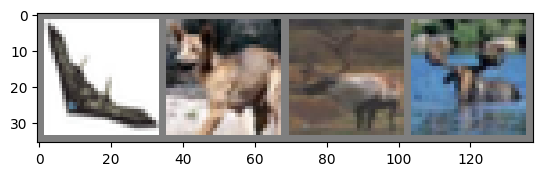

plane dog   deer  deer 


In [22]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

#### Define Model

In [23]:
import warnings
warnings.filterwarnings("ignore") 

import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # Layer 1  which has six kernels of size 5x5 with padding 0 and stride 1    
        # input (1, 28, 28) padding to(1,32,32) 
        # output(6, 28, 28)   
        self.conv_pool1 = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=6,kernel_size=(5, 5),padding=0),  
            #nn.BatchNorm2d(6),       
            nn.ReLU(),                     
            nn.MaxPool2d(2, stride=2)                 # output(6, 14, 14)
        )
       

        self.conv_pool2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),  # output(16, 10, 10)
            #nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2)) # output(16, 5, 5)
        
        # the fully connected layer
        self.fc1 = nn.Sequential(                  
            nn.Linear(16*5*5, 120),
            nn.ReLU()
        )

     
        self.fc2 = nn.Sequential(
            nn.Linear(120, 84),
            nn.ReLU()
        )
        # the output layer
        self.out = nn.Sequential(
            nn.Linear(84, 10),

        )

    # 前向传播
    def forward(self, x):

        x = self.conv_pool1(x)
        x = self.conv_pool2(x)
        x = x.view(x.size(0), -1)       # resize to 2-dims(batch_size, 16*5*5) 展平成1维
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        return x


net = Net().to(device)
print(net)

Net(
  (conv_pool1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_pool2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=120, out_features=84, bias=True)
    (1): ReLU()
  )
  (out): Sequential(
    (0): Linear(in_features=84, out_features=10, bias=True)
  )
)


#### Check Params

In [24]:
params = list(net.parameters())
print(len(params)) # contains weights and bias
print(params[0].size()) # conv1's weight
print(params[1].size()) # conv1's bias

10
torch.Size([6, 3, 5, 5])
torch.Size([6])


#### Optimizer & Loss Function

In [25]:
import torch.optim as optim

criterion = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(net.parameters())
#optimizer = optim.Adam(net.parameters(), lr=0.003)
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.5)

#### Training

In [26]:
from tqdm import tqdm

#存储训练过程
history = {'Train Loss':[],'Test Loss':[],'Test Accuracy':[]}

for epoch in range(1, n_epochs + 1):
    #构建tqdm进度条
    processBar = tqdm(train_loader,unit = 'step')
    #打开网络的训练模式
    net.train(True)
    #开始对训练集的DataLoader进行迭代
    totalTrainLoss = 0.0
   
    for step,(trainImgs,labels) in enumerate(processBar):
        
        #将图像和标签传输进device中
        trainImgs = trainImgs.to(device)
        labels = labels.to(device)
        
        #清空模型的梯度
        optimizer.zero_grad()
        
        #对模型进行前向推理
        outputs = net(trainImgs)
        
        #计算本轮推理的Loss值
        loss = criterion(outputs,labels)
        #计算本轮推理的准确率
        predictions = torch.argmax(outputs, dim = 1)
        accuracy = torch.sum(predictions == labels)/float(labels.shape[0])
        
        #进行反向传播求出模型参数的梯度
        loss.backward()
        #使用迭代器更新模型权重
        optimizer.step()

        #将本step结果进行可视化处理
        processBar.set_description("[%d/%d] Loss: %.4f, Acc: %.4f" % 
                                    (epoch,n_epochs,loss.item(),accuracy.item()))

        totalTrainLoss+= loss
        
        if step == len(processBar)-1:
            correct,totalLoss = 0,0
            totalSize = 0
            net.train(False)
            for testImgs,labels in test_loader:
                testImgs = testImgs.to(device)
                labels = labels.to(device)
                outputs = net(testImgs)
                loss = criterion(outputs,labels)
                predictions = torch.argmax(outputs,dim = 1)
                totalSize += labels.size(0)
                totalLoss += loss
                correct += torch.sum(predictions == labels)
            testAccuracy = correct/float(totalSize)
            testLoss = totalLoss/float(len(test_loader))
            trainLoss = totalTrainLoss/float(len(train_loader))
            history['Train Loss'].append(trainLoss.item())
            history['Test Loss'].append(testLoss.item())
            history['Test Accuracy'].append(testAccuracy.item())
            processBar.set_description("[%d/%d] Loss: %.4f, Acc: %.4f, Test Loss: %.4f, Test Acc: %.4f" % 
                                   (epoch,n_epochs,loss.item(),accuracy.item(),testLoss.item(),testAccuracy.item()))
    processBar.close()

[1/5] Loss: 2.2450, Acc: 0.0000:   0%|          | 12/12500 [00:00<05:29, 37.90step/s]

[1/5] Loss: 0.6272, Acc: 0.5000, Test Loss: 1.4207, Test Acc: 0.4857: 100%|██████████| 12500/12500 [03:43<00:00, 55.99step/s]
[2/5] Loss: 0.5741, Acc: 0.7500, Test Loss: 1.2850, Test Acc: 0.5429: 100%|██████████| 12500/12500 [02:50<00:00, 73.44step/s]
[3/5] Loss: 1.2117, Acc: 0.2500, Test Loss: 1.2995, Test Acc: 0.5537: 100%|██████████| 12500/12500 [04:32<00:00, 45.92step/s]
[4/5] Loss: 0.5554, Acc: 0.5000, Test Loss: 1.2166, Test Acc: 0.5806: 100%|██████████| 12500/12500 [04:23<00:00, 47.41step/s]
[5/5] Loss: 1.6737, Acc: 0.5000, Test Loss: 1.2355, Test Acc: 0.5767: 100%|██████████| 12500/12500 [04:14<00:00, 49.15step/s]


#### Loss and Acc

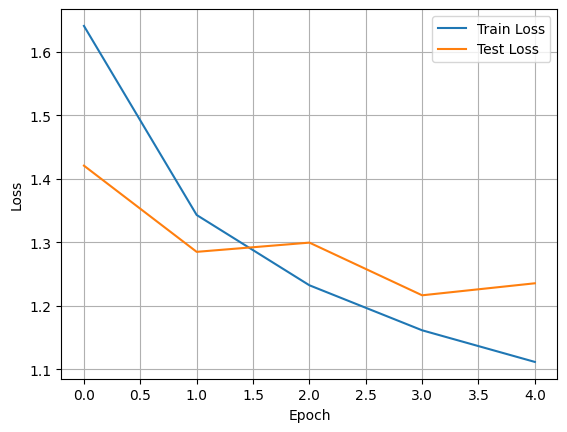

In [27]:
plt.plot(history['Train Loss'],label = 'Train Loss')
plt.plot(history['Test Loss'],label = 'Test Loss')
plt.legend(loc='best')
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

#### Save Model

In [28]:
torch.save(net.state_dict(),'./models/cifar.pth')

#### Load Test

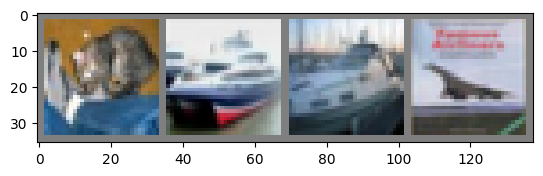

GroundTruth:  cat   ship  ship  plane


In [29]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [30]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  plane plane


#### Total Check

In [31]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 57 %
